In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score
import joblib
import warnings
warnings.filterwarnings("ignore")

In [68]:
!pip install psycopg2-binary sqlalchemy pandas numpy matplotlib seaborn


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings('ignore')

# ----------------------------------------------------
# 1️⃣  Create PostgreSQL database connection
# ----------------------------------------------------
def create_db_connection():
    connection_string = (
        "xxxxxxxxxxxxxxxxxxx"
        "xxxxxxxxxxxxxxxxxxx"
    )
    engine = create_engine(connection_string)
    return engine

print("Connecting to PostgreSQL database...")
engine = create_db_connection()
print("✅ Connection established successfully!")

Connecting to PostgreSQL database...
✅ Connection established successfully!


In [72]:
try:
    print("Loading loan_outcomes table...")
    loan_outcomes = pd.read_sql("SELECT * FROM loan_outcomes", engine)

    print("Loading user_attributes table...")
    user_attributes = pd.read_sql("SELECT * FROM user_attributes", engine)

    print("Loading 1% sample of gps_fixes table (safe for memory)...")
    gps_fixes = pd.read_sql(
        "SELECT * FROM gps_fixes TABLESAMPLE BERNOULLI(1)", engine
    )

    print("✅ Tables loaded successfully!")
    print(f"loan_outcomes shape: {loan_outcomes.shape}")
    print(f"user_attributes shape: {user_attributes.shape}")
    print(f"gps_fixes sample shape: {gps_fixes.shape}")

except Exception as e:
    print("❌ Error while loading tables!")
    print("Error details:", e)

Loading loan_outcomes table...
Loading user_attributes table...
Loading 1% sample of gps_fixes table (safe for memory)...
✅ Tables loaded successfully!
loan_outcomes shape: (400, 3)
user_attributes shape: (400, 3)
gps_fixes sample shape: (269, 9)


In [74]:
# View first few rows
display(loan_outcomes.head())
display(user_attributes.head())
display(gps_fixes.head())

# Null value overview
print("Null counts:")
print("Loan Outcomes:\n", loan_outcomes.isnull().sum())
print("\nUser Attributes:\n", user_attributes.isnull().sum())
print("\nGPS Fixes:\n", gps_fixes.isnull().sum())

,user_id,application_at,loan_outcome
0,1,2017-08-14 09:08:50.000000,defaulted
1,2,2016-05-17 10:10:12.447976,repaid
2,3,2016-10-20 10:07:20.459081,defaulted
3,4,2017-01-13 13:03:34.000000,defaulted
4,5,2016-11-03 15:41:39.124610,repaid


,user_id,age,cash_incoming_30days
0,1,42,8988.12
1,2,36,9968.12
2,3,27,59.04
3,4,38,2129.03
4,5,33,2102.53


,gps_fix_at,server_upload_at,longitude,latitude,accuracy,altitude,bearing,location_provider,user_id
0,2017-08-14 07:50:27,2017-08-14 09:05:27,36.895270,-1.341928,1409.0,0.0,0.0,fused,1
1,2017-08-15 05:18:00,2017-08-15 05:34:09,36.882162,-1.371128,1371.0,0.0,0.0,fused,1
2,2017-05-22 08:03:07,2017-05-22 08:04:27,34.717939,-0.078320,2627.0,0.0,0.0,fused,6
3,2017-11-02 15:19:29,2017-11-02 15:20:49,34.553190,0.516476,2893.0,0.0,0.0,fused,6
4,2018-08-06 09:03:44,2018-08-06 09:03:46,34.710946,-0.087649,10.0,1138.2,0.0,fused,13


Null counts:
Loan Outcomes:
 user_id           0
application_at    0
loan_outcome      0
dtype: int64

User Attributes:
 user_id                 0
age                     0
cash_incoming_30days    0
dtype: int64

GPS Fixes:
 gps_fix_at           0
server_upload_at     0
longitude            0
latitude             0
accuracy             0
altitude             0
bearing              0
location_provider    0
user_id              0
dtype: int64


In [76]:

# Define file paths (you can change folder names if needed)
loan_outcomes_path = "loan_outcomes.csv"
user_attributes_path = "user_attributes.csv"
gps_fixes_path = "gps_fixes.csv"

# Save as CSV files
loan_outcomes.to_csv(loan_outcomes_path, index=False)
user_attributes.to_csv(user_attributes_path, index=False)
gps_fixes.to_csv(gps_fixes_path, index=False)

print("✅ All tables exported successfully!")
print(f"Saved files:\n- {loan_outcomes_path}\n- {user_attributes_path}\n- {gps_fixes_path}")

✅ All tables exported successfully!
Saved files:
- loan_outcomes.csv
- user_attributes.csv
- gps_fixes.csv


In [88]:
print("✅ Data loaded successfully!")
print(f"gps_fixes: {gps_fixes.shape}, loan_outcomes: {loan_outcomes.shape}, user_attributes: {user_attributes.shape}")


✅ Data loaded successfully!
gps_fixes: (269, 9), loan_outcomes: (400, 3), user_attributes: (400, 3)


🔍 Starting Exploratory Data Analysis and Model Building...

📊 Exploratory Data Analysis

📈 Dataset Overview:
Loan Outcomes columns: ['user_id', 'application_at', 'loan_outcome', 'application_month', 'loan_default']
Loan Outcomes unique values:
loan_outcome
defaulted    200
repaid       200
Name: count, dtype: int64

User Attributes columns: ['user_id', 'age', 'cash_incoming_30days']

GPS Fixes columns: ['gps_fix_at', 'server_upload_at', 'longitude', 'latitude', 'accuracy', 'altitude', 'bearing', 'location_provider', 'user_id']

🎯 Creating target variable...
Unique loan outcomes: ['defaulted' 'repaid']
Target variable distribution:
loan_default
1    200
0    200
Name: count, dtype: int64


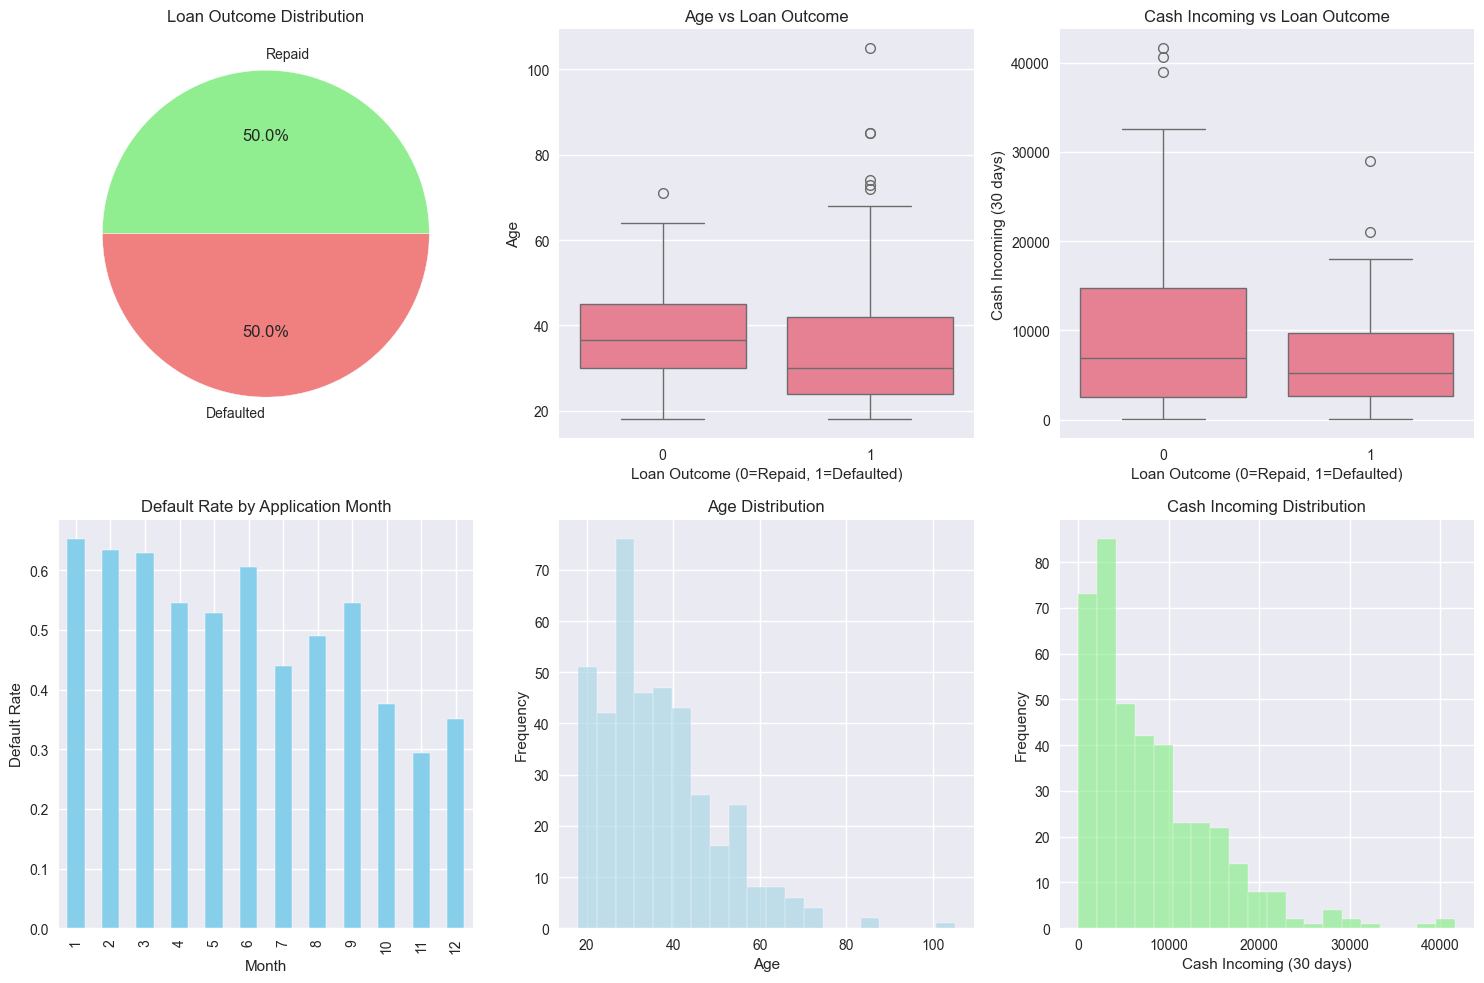


🛠️ Feature Engineering
Creating GPS-based features...
GPS features shape: (146, 9)

🔄 Merging datasets...
Merged dataset shape: (400, 15)
Missing values after merge: 2360
✅ Features engineered successfully!
New dataset shape: (400, 22)
Target distribution in merged data: loan_default
1    200
0    200
Name: count, dtype: int64

🔧 Data Preprocessing
Handling missing values...
Missing values per column:
user_id                  0
application_at           0
loan_outcome             0
application_month        0
loan_default             0
age                      0
cash_incoming_30days     0
gps_fix_count            0
longitude_std            0
latitude_std             0
accuracy_mean            0
altitude_mean            0
altitude_std             0
bearing_mean             0
bearing_std              0
age_group                1
cash_category            0
application_dayofweek    0
application_hour         0
young_borrower           0
low_cash_flow            0
unstable_location        0


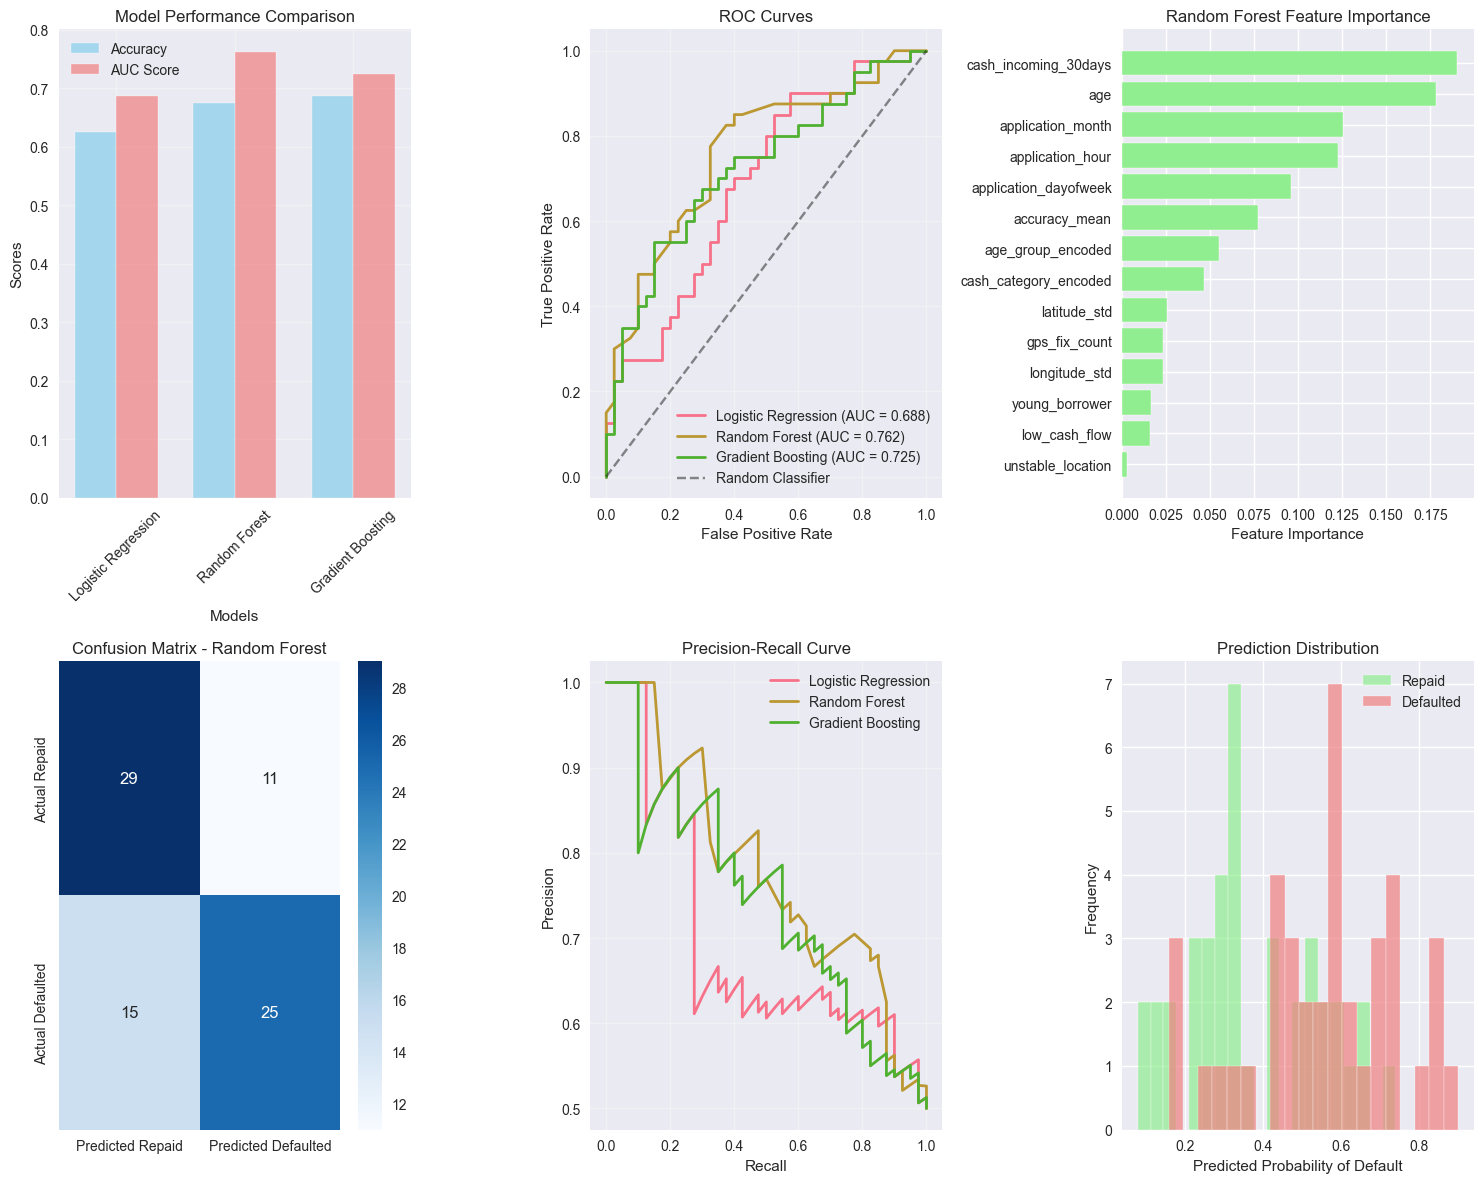


🏆 Best Model: Random Forest
Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.72      0.69        40
           1       0.69      0.62      0.66        40

    accuracy                           0.68        80
   macro avg       0.68      0.68      0.67        80
weighted avg       0.68      0.68      0.67        80



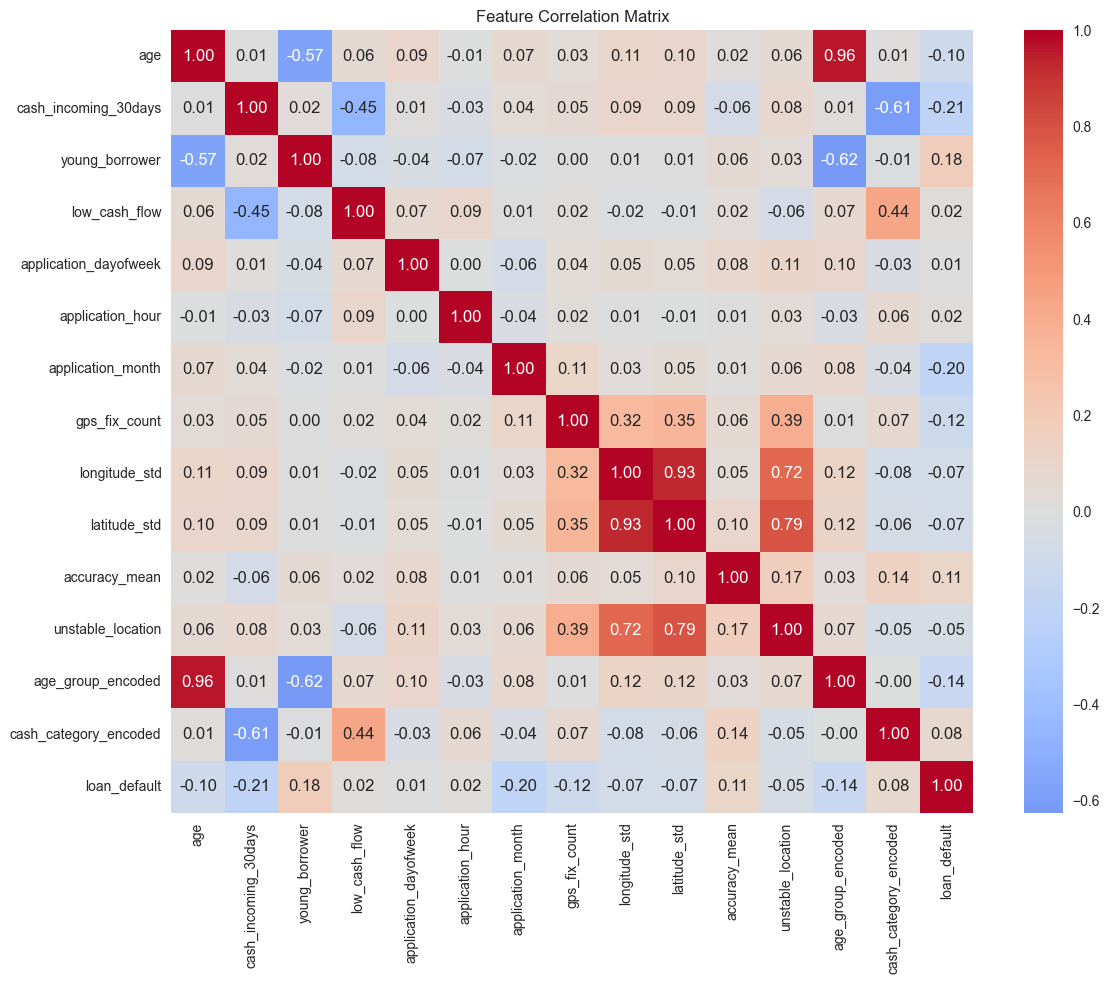


💾 Saving Model Artifacts...
✅ Model artifacts saved as 'loan_default_model.pkl'

🎯 PROJECT SUMMARY
📊 Dataset: 399 samples, 14 features
🎯 Target: Loan Default Prediction
🏆 Best Model: Random Forest
📈 Accuracy: 0.6750
🎯 AUC Score: 0.7625
💾 Model Saved: 'loan_default_model.pkl'

✅ Machine Learning Pipeline Completed Successfully!


In [108]:
# Import additional libraries needed for the ML pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, confusion_matrix, accuracy_score, precision_recall_curve
import joblib
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("🔍 Starting Exploratory Data Analysis and Model Building...")

# ----------------------------------------------------
# 2️⃣ EXPLORATORY DATA ANALYSIS
# ----------------------------------------------------

print("\n📊 Exploratory Data Analysis")

# 2.1 Let's first understand the actual data structure
print("\n📈 Dataset Overview:")
print("Loan Outcomes columns:", loan_outcomes.columns.tolist())
print("Loan Outcomes unique values:")
print(loan_outcomes['loan_outcome'].value_counts())

print("\nUser Attributes columns:", user_attributes.columns.tolist())
print("\nGPS Fixes columns:", gps_fixes.columns.tolist())

# 2.2 Create target variable from loan_outcome PROPERLY
print("\n🎯 Creating target variable...")
print("Unique loan outcomes:", loan_outcomes['loan_outcome'].unique())

# Remove any existing loan_default column if it exists
if 'loan_default' in loan_outcomes.columns:
    loan_outcomes = loan_outcomes.drop('loan_default', axis=1)

# Convert loan_outcome to binary target (1 for default, 0 for paid)
loan_outcomes['loan_default'] = (loan_outcomes['loan_outcome'] == 'defaulted').astype(int)
print("Target variable distribution:")
print(loan_outcomes['loan_default'].value_counts())

# 2.3 Basic visualizations
plt.figure(figsize=(15, 10))

# Plot 1: Target variable distribution
plt.subplot(2, 3, 1)
target_counts = loan_outcomes['loan_default'].value_counts()
plt.pie(target_counts.values, labels=['Repaid', 'Defaulted'], autopct='%1.1f%%', 
        colors=['lightgreen', 'lightcoral'])
plt.title('Loan Outcome Distribution')

# Plot 2: Age distribution by loan outcome
plt.subplot(2, 3, 2)
merged_temp = pd.merge(loan_outcomes, user_attributes, on='user_id', how='inner')
sns.boxplot(data=merged_temp, x='loan_default', y='age')
plt.title('Age vs Loan Outcome')
plt.xlabel('Loan Outcome (0=Repaid, 1=Defaulted)')
plt.ylabel('Age')

# Plot 3: Cash incoming distribution by loan outcome
plt.subplot(2, 3, 3)
sns.boxplot(data=merged_temp, x='loan_default', y='cash_incoming_30days')
plt.title('Cash Incoming vs Loan Outcome')
plt.xlabel('Loan Outcome (0=Repaid, 1=Defaulted)')
plt.ylabel('Cash Incoming (30 days)')

# Plot 4: Application month analysis
plt.subplot(2, 3, 4)
loan_outcomes['application_month'] = loan_outcomes['application_at'].dt.month
monthly_defaults = loan_outcomes.groupby('application_month')['loan_default'].mean()
monthly_defaults.plot(kind='bar', color='skyblue')
plt.title('Default Rate by Application Month')
plt.xlabel('Month')
plt.ylabel('Default Rate')

# Plot 5: Age distribution
plt.subplot(2, 3, 5)
user_attributes['age'].hist(bins=20, alpha=0.7, color='lightblue')
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Frequency')

# Plot 6: Cash incoming distribution
plt.subplot(2, 3, 6)
user_attributes['cash_incoming_30days'].hist(bins=20, alpha=0.7, color='lightgreen')
plt.title('Cash Incoming Distribution')
plt.xlabel('Cash Incoming (30 days)')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

# ----------------------------------------------------
# 3️⃣ FEATURE ENGINEERING WITH GPS DATA
# ----------------------------------------------------

print("\n🛠️ Feature Engineering")

# 3.1 Create features from GPS data
print("Creating GPS-based features...")
gps_features = gps_fixes.groupby('user_id').agg({
    'longitude': ['count', 'std'],  # Number of GPS points, stability
    'latitude': 'std',              # Location stability
    'accuracy': 'mean',             # Average GPS accuracy
    'altitude': ['mean', 'std'],    # Altitude patterns
    'bearing': ['mean', 'std']      # Movement patterns
}).reset_index()

# Flatten column names
gps_features.columns = ['user_id', 'gps_fix_count', 'longitude_std', 
                       'latitude_std', 'accuracy_mean', 'altitude_mean', 
                       'altitude_std', 'bearing_mean', 'bearing_std']

print(f"GPS features shape: {gps_features.shape}")

# 3.2 Merge all datasets
print("\n🔄 Merging datasets...")
merged_data = pd.merge(loan_outcomes, user_attributes, on='user_id', how='inner')
merged_data = pd.merge(merged_data, gps_features, on='user_id', how='left')

print(f"Merged dataset shape: {merged_data.shape}")
print(f"Missing values after merge: {merged_data.isnull().sum().sum()}")

# 3.3 Create additional features
def create_features(df):
    """Create engineered features for modeling"""
    
    # Age groups
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 25, 35, 45, 55, 100], 
                            labels=['18-25', '26-35', '36-45', '46-55', '55+'])
    
    # Cash incoming categories
    df['cash_category'] = pd.cut(df['cash_incoming_30days'],
                                bins=[0, 1000, 5000, 10000, float('inf')],
                                labels=['Very Low', 'Low', 'Medium', 'High'])
    
    # Application features
    df['application_dayofweek'] = df['application_at'].dt.dayofweek
    df['application_hour'] = df['application_at'].dt.hour
    df['application_month'] = df['application_at'].dt.month
    
    # Risk flags
    df['young_borrower'] = (df['age'] < 25).astype(int)
    df['low_cash_flow'] = (df['cash_incoming_30days'] < 2000).astype(int)
    
    # GPS stability flags (handle NaN values)
    if 'longitude_std' in df.columns:
        df['unstable_location'] = (df['longitude_std'] > 0.1).astype(int)
        # Fill NaN values from GPS features
        gps_cols = ['gps_fix_count', 'longitude_std', 'latitude_std', 'accuracy_mean', 
                    'altitude_mean', 'altitude_std', 'bearing_mean', 'bearing_std', 'unstable_location']
        for col in gps_cols:
            if col in df.columns:
                df[col] = df[col].fillna(df[col].median())
    
    return df

# Apply feature engineering
merged_data = create_features(merged_data)

print("✅ Features engineered successfully!")
print(f"New dataset shape: {merged_data.shape}")
print(f"Target distribution in merged data: {merged_data['loan_default'].value_counts()}")

# ----------------------------------------------------
# 4️⃣ DATA PREPROCESSING
# ----------------------------------------------------

print("\n🔧 Data Preprocessing")

# 4.1 Handle missing values
print("Handling missing values...")
print("Missing values per column:")
print(merged_data.isnull().sum())

# Remove any remaining missing values
initial_shape = merged_data.shape[0]
merged_data = merged_data.dropna()
final_shape = merged_data.shape[0]
print(f"Removed {initial_shape - final_shape} rows with missing values")
print(f"Final dataset shape: {merged_data.shape}")

# Check if we have both classes in target
target_distribution = merged_data['loan_default'].value_counts()
print(f"Final target distribution: {target_distribution}")

if len(target_distribution) < 2:
    print("❌ WARNING: Only one class present in target variable!")
    print("This will cause issues with classification models.")
    # Let's check what happened
    print("Checking loan_outcome values in final data:")
    print(merged_data['loan_outcome'].value_counts())
    print("❌ Cannot proceed with model training due to insufficient class distribution.")
else:
    print("✅ Both classes present in target variable. Proceeding with model training.")

    # 4.2 Encode categorical variables
    print("Encoding categorical variables...")
    categorical_columns = ['age_group', 'cash_category']
    label_encoders = {}

    for col in categorical_columns:
        if col in merged_data.columns:
            le = LabelEncoder()
            merged_data[col + '_encoded'] = le.fit_transform(merged_data[col].astype(str))
            label_encoders[col] = le

    # 4.3 Prepare features and target
    # Select features for modeling
    feature_columns = [
        'age', 'cash_incoming_30days',  # Basic user attributes
        'young_borrower', 'low_cash_flow',  # Risk flags
        'application_dayofweek', 'application_hour', 'application_month'  # Application timing
    ]

    # Add GPS features if available
    gps_feature_cols = ['gps_fix_count', 'longitude_std', 'latitude_std', 'accuracy_mean', 'unstable_location']
    for col in gps_feature_cols:
        if col in merged_data.columns:
            feature_columns.append(col)

    # Add encoded categorical features
    feature_columns += [col + '_encoded' for col in categorical_columns if col in merged_data.columns]

    # Remove any columns that might not exist
    feature_columns = [col for col in feature_columns if col in merged_data.columns]

    X = merged_data[feature_columns]
    y = merged_data['loan_default']

    print(f"Final feature set ({len(feature_columns)} features): {feature_columns}")
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    print(f"Target distribution:\n{y.value_counts()}")

    # 4.4 Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Training target distribution:\n{y_train.value_counts()}")
    print(f"Test target distribution:\n{y_test.value_counts()}")

    # 4.5 Feature scaling
    print("Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ----------------------------------------------------
    # 5️⃣ MODEL TRAINING
    # ----------------------------------------------------

    print("\n🤖 Training Machine Learning Models")

    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100)
    }

    # Store model results
    model_results = {}
    trained_models = {}

    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        
        # Use scaled features for Logistic Regression, original for tree-based models
        if model_name == 'Logistic Regression':
            X_train_used = X_train_scaled
            X_test_used = X_test_scaled
        else:
            X_train_used = X_train
            X_test_used = X_test
        
        try:
            # Train model
            model.fit(X_train_used, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test_used)
            y_pred_proba = model.predict_proba(X_test_used)[:, 1]
            
            # Calculate metrics
            accuracy = accuracy_score(y_test, y_pred)
            auc_score = roc_auc_score(y_test, y_pred_proba)
            
            # Store results
            model_results[model_name] = {
                'model': model,
                'accuracy': accuracy,
                'auc_score': auc_score,
                'y_pred': y_pred,
                'y_pred_proba': y_pred_proba
            }
            trained_models[model_name] = model
            
            print(f"✅ {model_name} trained:")
            print(f"   Accuracy: {accuracy:.4f}")
            print(f"   AUC Score: {auc_score:.4f}")
            
        except Exception as e:
            print(f"❌ Error training {model_name}: {e}")

    # Only proceed if we have successful models
    if model_results:
        # ----------------------------------------------------
        # 6️⃣ MODEL EVALUATION AND VISUALIZATION
        # ----------------------------------------------------

        print("\n📊 Model Evaluation and Visualization")

        # 6.1 Model comparison
        plt.figure(figsize=(15, 12))

        # Plot 1: Model performance comparison
        plt.subplot(2, 3, 1)
        model_names = list(model_results.keys())
        accuracies = [model_results[name]['accuracy'] for name in model_names]
        auc_scores = [model_results[name]['auc_score'] for name in model_names]

        x = np.arange(len(model_names))
        width = 0.35

        plt.bar(x - width/2, accuracies, width, label='Accuracy', alpha=0.7, color='skyblue')
        plt.bar(x + width/2, auc_scores, width, label='AUC Score', alpha=0.7, color='lightcoral')

        plt.xlabel('Models')
        plt.ylabel('Scores')
        plt.title('Model Performance Comparison')
        plt.xticks(x, model_names, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 6.2 ROC Curves
        plt.subplot(2, 3, 2)
        for model_name, results in model_results.items():
            fpr, tpr, _ = roc_curve(y_test, results['y_pred_proba'])
            plt.plot(fpr, tpr, label=f'{model_name} (AUC = {results["auc_score"]:.3f})', linewidth=2)

        plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 6.3 Feature Importance (for Random Forest)
        plt.subplot(2, 3, 3)
        if 'Random Forest' in trained_models:
            best_model = trained_models['Random Forest']
            feature_importance = pd.DataFrame({
                'feature': feature_columns,
                'importance': best_model.feature_importances_
            }).sort_values('importance', ascending=True)

            plt.barh(feature_importance['feature'], feature_importance['importance'], color='lightgreen')
            plt.xlabel('Feature Importance')
            plt.title('Random Forest Feature Importance')
        else:
            plt.text(0.5, 0.5, 'Random Forest not available', ha='center', va='center')
            plt.title('Feature Importance Not Available')

        # 6.4 Confusion Matrix for best model
        plt.subplot(2, 3, 4)
        best_model_name = max(model_results.items(), key=lambda x: x[1]['auc_score'])[0]
        best_results = model_results[best_model_name]
        cm = confusion_matrix(y_test, best_results['y_pred'])

        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                    xticklabels=['Predicted Repaid', 'Predicted Defaulted'],
                    yticklabels=['Actual Repaid', 'Actual Defaulted'])
        plt.title(f'Confusion Matrix - {best_model_name}')

        # 6.5 Precision-Recall Curve
        plt.subplot(2, 3, 5)
        for model_name, results in model_results.items():
            precision, recall, _ = precision_recall_curve(y_test, results['y_pred_proba'])
            plt.plot(recall, precision, label=model_name, linewidth=2)

        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 6.6 Prediction Distribution
        plt.subplot(2, 3, 6)
        plt.hist(best_results['y_pred_proba'][y_test == 0], alpha=0.7, label='Repaid', bins=20, color='lightgreen')
        plt.hist(best_results['y_pred_proba'][y_test == 1], alpha=0.7, label='Defaulted', bins=20, color='lightcoral')
        plt.xlabel('Predicted Probability of Default')
        plt.ylabel('Frequency')
        plt.title('Prediction Distribution')
        plt.legend()

        plt.tight_layout()
        plt.show()

        # ----------------------------------------------------
        # 7️⃣ DETAILED MODEL ANALYSIS
        # ----------------------------------------------------

        print(f"\n🏆 Best Model: {best_model_name}")
        print("Detailed Classification Report:")
        print(classification_report(y_test, best_results['y_pred']))

        # 7.1 Feature correlation analysis
        plt.figure(figsize=(12, 10))
        correlation_matrix = merged_data[feature_columns + ['loan_default']].corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()

        # ----------------------------------------------------
        # 8️⃣ MODEL DEPLOYMENT PREPARATION
        # ----------------------------------------------------

        print("\n💾 Saving Model Artifacts...")

        # Save the best model and preprocessing objects
        model_artifacts = {
            'model': trained_models[best_model_name],
            'scaler': scaler,
            'label_encoders': label_encoders,
            'feature_columns': feature_columns,
            'model_name': best_model_name,
            'performance': model_results[best_model_name]
        }

        # Save model artifacts
        joblib.dump(model_artifacts, 'loan_default_model.pkl')
        print("✅ Model artifacts saved as 'loan_default_model.pkl'")

        # ----------------------------------------------------
        # 9️⃣ SUMMARY
        # ----------------------------------------------------

        print("\n🎯 PROJECT SUMMARY")
        print("="*50)
        print(f"📊 Dataset: {merged_data.shape[0]} samples, {len(feature_columns)} features")
        print(f"🎯 Target: Loan Default Prediction")
        print(f"🏆 Best Model: {best_model_name}")
        print(f"📈 Accuracy: {model_results[best_model_name]['accuracy']:.4f}")
        print(f"🎯 AUC Score: {model_results[best_model_name]['auc_score']:.4f}")
        print(f"💾 Model Saved: 'loan_default_model.pkl'")
        print("="*50)

        print("\n✅ Machine Learning Pipeline Completed Successfully!")
    else:
        print("❌ No models were successfully trained. Please check your data.")

🔍 Starting Exploratory Data Analysis and Model Building...

📊 Exploratory Data Analysis

📈 Dataset Overview:
Loan Outcomes columns: ['user_id', 'application_at', 'loan_outcome', 'application_month', 'loan_default']
Loan Outcomes unique values:
loan_outcome
defaulted    200
repaid       200
Name: count, dtype: int64

User Attributes columns: ['user_id', 'age', 'cash_incoming_30days']

GPS Fixes columns: ['gps_fix_at', 'server_upload_at', 'longitude', 'latitude', 'accuracy', 'altitude', 'bearing', 'location_provider', 'user_id']

🎯 Creating target variable...
Unique loan outcomes: ['defaulted' 'repaid']
Target variable distribution:
loan_default
1    200
0    200
Name: count, dtype: int64

🛠️ Feature Engineering
Creating GPS-based features...
GPS features shape: (146, 9)

🔄 Merging datasets...
Merged dataset shape: (400, 15)
Missing values after merge: 2360
✅ Features engineered successfully!
New dataset shape: (400, 22)
Target distribution in merged data: loan_default
1    200
0    200


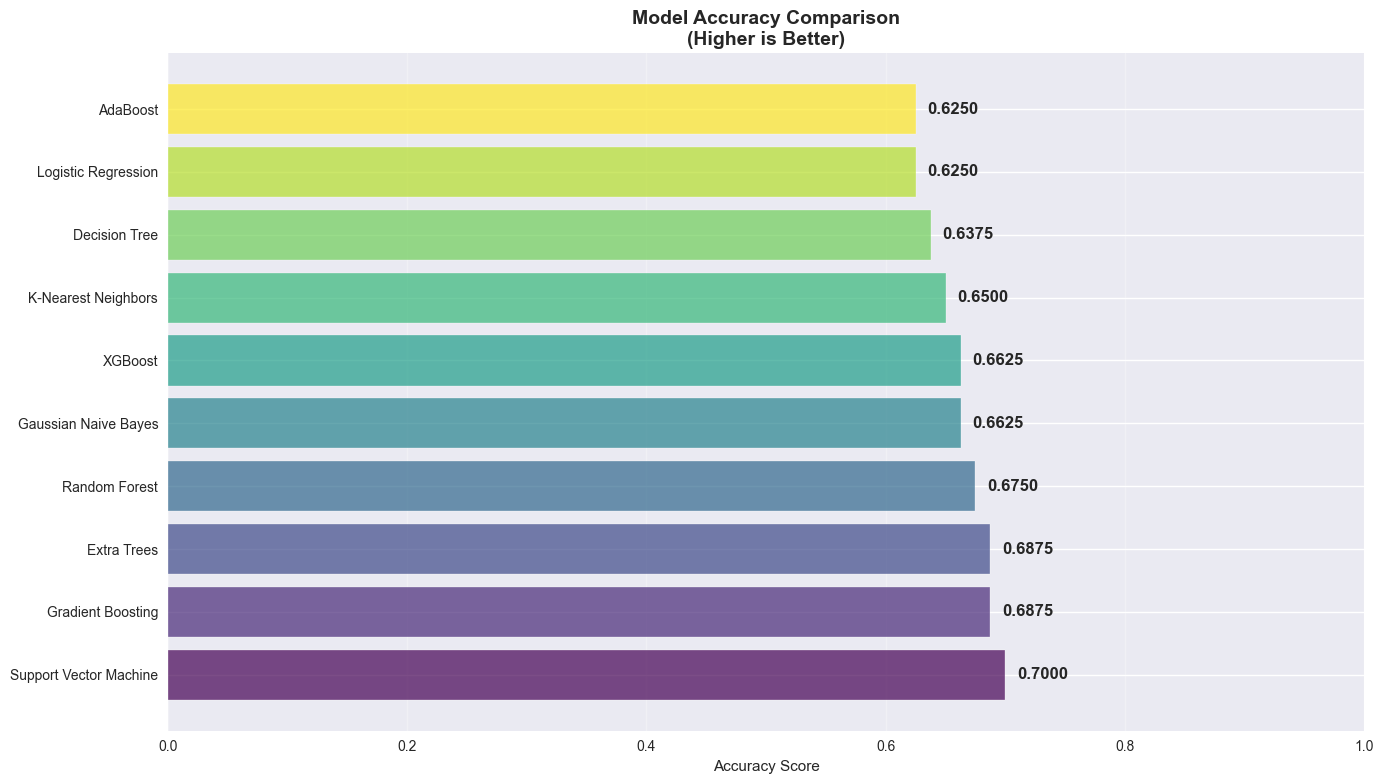


🏆 BEST MODEL: Support Vector Machine
📈 BEST ACCURACY: 0.7000

📊 ACCURACY STATISTICS:
   Highest Accuracy: 0.7000
   Lowest Accuracy: 0.6250
   Average Accuracy: 0.6613
   Accuracy Range: 0.0750

🔍 PERFORMANCE BY MODEL TYPE:
   Ensemble Models Average: 0.6675
   Traditional Models Average: 0.6550

💾 Saving Best Model...
✅ Best model artifacts saved as 'loan_default_model.pkl'

🎯 FINAL PROJECT SUMMARY
📊 Dataset: 399 samples, 14 features
🎯 Target: Loan Default Prediction
🔢 Models Tested: 10
🏆 Best Model: Support Vector Machine
📈 Best Accuracy: 0.7000
📊 Accuracy Range: 0.6250 - 0.7000
💾 Model Saved: 'loan_default_model.pkl'

✅ Machine Learning Pipeline Completed Successfully!


In [110]:
# Import additional libraries needed for the ML pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

print("🔍 Starting Exploratory Data Analysis and Model Building...")

# ----------------------------------------------------
# 2️⃣ EXPLORATORY DATA ANALYSIS
# ----------------------------------------------------

print("\n📊 Exploratory Data Analysis")

# 2.1 Let's first understand the actual data structure
print("\n📈 Dataset Overview:")
print("Loan Outcomes columns:", loan_outcomes.columns.tolist())
print("Loan Outcomes unique values:")
print(loan_outcomes['loan_outcome'].value_counts())

print("\nUser Attributes columns:", user_attributes.columns.tolist())
print("\nGPS Fixes columns:", gps_fixes.columns.tolist())

# 2.2 Create target variable from loan_outcome PROPERLY
print("\n🎯 Creating target variable...")
print("Unique loan outcomes:", loan_outcomes['loan_outcome'].unique())

# Remove any existing loan_default column if it exists
if 'loan_default' in loan_outcomes.columns:
    loan_outcomes = loan_outcomes.drop('loan_default', axis=1)

# Convert loan_outcome to binary target (1 for default, 0 for paid)
loan_outcomes['loan_default'] = (loan_outcomes['loan_outcome'] == 'defaulted').astype(int)
print("Target variable distribution:")
print(loan_outcomes['loan_default'].value_counts())

# ----------------------------------------------------
# 3️⃣ FEATURE ENGINEERING WITH GPS DATA
# ----------------------------------------------------

print("\n🛠️ Feature Engineering")

# 3.1 Create features from GPS data
print("Creating GPS-based features...")
gps_features = gps_fixes.groupby('user_id').agg({
    'longitude': ['count', 'std'],  # Number of GPS points, stability
    'latitude': 'std',              # Location stability
    'accuracy': 'mean',             # Average GPS accuracy
    'altitude': ['mean', 'std'],    # Altitude patterns
    'bearing': ['mean', 'std']      # Movement patterns
}).reset_index()

# Flatten column names
gps_features.columns = ['user_id', 'gps_fix_count', 'longitude_std', 
                       'latitude_std', 'accuracy_mean', 'altitude_mean', 
                       'altitude_std', 'bearing_mean', 'bearing_std']

print(f"GPS features shape: {gps_features.shape}")

# 3.2 Merge all datasets
print("\n🔄 Merging datasets...")
merged_data = pd.merge(loan_outcomes, user_attributes, on='user_id', how='inner')
merged_data = pd.merge(merged_data, gps_features, on='user_id', how='left')

print(f"Merged dataset shape: {merged_data.shape}")
print(f"Missing values after merge: {merged_data.isnull().sum().sum()}")

# 3.3 Create additional features
def create_features(df):
    """Create engineered features for modeling"""
    
    # Age groups
    df['age_group'] = pd.cut(df['age'], 
                            bins=[0, 25, 35, 45, 55, 100], 
                            labels=['18-25', '26-35', '36-45', '46-55', '55+'])
    
    # Cash incoming categories
    df['cash_category'] = pd.cut(df['cash_incoming_30days'],
                                bins=[0, 1000, 5000, 10000, float('inf')],
                                labels=['Very Low', 'Low', 'Medium', 'High'])
    
    # Application features
    df['application_dayofweek'] = df['application_at'].dt.dayofweek
    df['application_hour'] = df['application_at'].dt.hour
    df['application_month'] = df['application_at'].dt.month
    
    # Risk flags
    df['young_borrower'] = (df['age'] < 25).astype(int)
    df['low_cash_flow'] = (df['cash_incoming_30days'] < 2000).astype(int)
    
    # GPS stability flags (handle NaN values)
    if 'longitude_std' in df.columns:
        df['unstable_location'] = (df['longitude_std'] > 0.1).astype(int)
        # Fill NaN values from GPS features
        gps_cols = ['gps_fix_count', 'longitude_std', 'latitude_std', 'accuracy_mean', 
                    'altitude_mean', 'altitude_std', 'bearing_mean', 'bearing_std', 'unstable_location']
        for col in gps_cols:
            if col in df.columns:
                df[col] = df[col].fillna(df[col].median())
    
    return df

# Apply feature engineering
merged_data = create_features(merged_data)

print("✅ Features engineered successfully!")
print(f"New dataset shape: {merged_data.shape}")
print(f"Target distribution in merged data: {merged_data['loan_default'].value_counts()}")

# ----------------------------------------------------
# 4️⃣ DATA PREPROCESSING
# ----------------------------------------------------

print("\n🔧 Data Preprocessing")

# 4.1 Handle missing values
print("Handling missing values...")
print("Missing values per column:")
print(merged_data.isnull().sum())

# Remove any remaining missing values
initial_shape = merged_data.shape[0]
merged_data = merged_data.dropna()
final_shape = merged_data.shape[0]
print(f"Removed {initial_shape - final_shape} rows with missing values")
print(f"Final dataset shape: {merged_data.shape}")

# Check if we have both classes in target
target_distribution = merged_data['loan_default'].value_counts()
print(f"Final target distribution: {target_distribution}")

if len(target_distribution) < 2:
    print("❌ WARNING: Only one class present in target variable!")
    print("This will cause issues with classification models.")
    print("❌ Cannot proceed with model training due to insufficient class distribution.")
else:
    print("✅ Both classes present in target variable. Proceeding with model training.")

    # 4.2 Encode categorical variables
    print("Encoding categorical variables...")
    categorical_columns = ['age_group', 'cash_category']
    label_encoders = {}

    for col in categorical_columns:
        if col in merged_data.columns:
            le = LabelEncoder()
            merged_data[col + '_encoded'] = le.fit_transform(merged_data[col].astype(str))
            label_encoders[col] = le

    # 4.3 Prepare features and target
    # Select features for modeling
    feature_columns = [
        'age', 'cash_incoming_30days',  # Basic user attributes
        'young_borrower', 'low_cash_flow',  # Risk flags
        'application_dayofweek', 'application_hour', 'application_month'  # Application timing
    ]

    # Add GPS features if available
    gps_feature_cols = ['gps_fix_count', 'longitude_std', 'latitude_std', 'accuracy_mean', 'unstable_location']
    for col in gps_feature_cols:
        if col in merged_data.columns:
            feature_columns.append(col)

    # Add encoded categorical features
    feature_columns += [col + '_encoded' for col in categorical_columns if col in merged_data.columns]

    # Remove any columns that might not exist
    feature_columns = [col for col in feature_columns if col in merged_data.columns]

    X = merged_data[feature_columns]
    y = merged_data['loan_default']

    print(f"Final feature set ({len(feature_columns)} features): {feature_columns}")
    print(f"X shape: {X.shape}, y shape: {y.shape}")
    print(f"Target distribution:\n{y.value_counts()}")

    # 4.4 Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    print(f"Training target distribution:\n{y_train.value_counts()}")
    print(f"Test target distribution:\n{y_test.value_counts()}")

    # 4.5 Feature scaling
    print("Scaling features...")
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # ----------------------------------------------------
    # 5️⃣ MODEL TRAINING WITH MULTIPLE ALGORITHMS
    # ----------------------------------------------------

    print("\n🤖 Training Multiple Machine Learning Models")

    # Define multiple models for comparison
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
        'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
        'Support Vector Machine': SVC(random_state=42, probability=True),
        'K-Nearest Neighbors': KNeighborsClassifier(),
        'Decision Tree': DecisionTreeClassifier(random_state=42),
        'AdaBoost': AdaBoostClassifier(random_state=42, n_estimators=100),
        'Extra Trees': ExtraTreesClassifier(random_state=42, n_estimators=100),
        'Gaussian Naive Bayes': GaussianNB(),
        'XGBoost': XGBClassifier(random_state=42, n_estimators=100)
    }

    # Store model results
    model_results = {}
    trained_models = {}

    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name}...")
        
        # Use scaled features for models that need scaling, original for tree-based models
        if model_name in ['Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors', 'Gaussian Naive Bayes']:
            X_train_used = X_train_scaled
            X_test_used = X_test_scaled
        else:
            X_train_used = X_train
            X_test_used = X_test
        
        try:
            # Train model
            model.fit(X_train_used, y_train)
            
            # Make predictions
            y_pred = model.predict(X_test_used)
            
            # Calculate accuracy
            accuracy = accuracy_score(y_test, y_pred)
            
            # Store results
            model_results[model_name] = {
                'model': model,
                'accuracy': accuracy,
                'y_pred': y_pred
            }
            trained_models[model_name] = model
            
            print(f"✅ {model_name} trained:")
            print(f"   Accuracy: {accuracy:.4f}")
            
        except Exception as e:
            print(f"❌ Error training {model_name}: {e}")

    # Only proceed if we have successful models
    if model_results:
        # ----------------------------------------------------
        # 6️⃣ MODEL COMPARISON - ACCURACY FOCUSED
        # ----------------------------------------------------

        print("\n📊 MODEL ACCURACY COMPARISON")
        print("="*60)

        # Sort models by accuracy (descending)
        sorted_results = sorted(model_results.items(), key=lambda x: x[1]['accuracy'], reverse=True)

        # Display accuracy comparison
        print("\n🏆 MODEL ACCURACY RANKING:")
        print("-" * 40)
        for i, (model_name, results) in enumerate(sorted_results, 1):
            print(f"{i:2d}. {model_name:25} Accuracy: {results['accuracy']:.4f}")

        print("="*60)

        # 6.1 Visualize accuracy comparison
        plt.figure(figsize=(14, 8))
        
        # Create accuracy comparison plot
        model_names = [result[0] for result in sorted_results]
        accuracies = [result[1]['accuracy'] for result in sorted_results]
        
        colors = plt.cm.viridis(np.linspace(0, 1, len(model_names)))
        
        bars = plt.barh(model_names, accuracies, color=colors, alpha=0.7)
        plt.xlabel('Accuracy Score')
        plt.title('Model Accuracy Comparison\n(Higher is Better)', fontsize=14, fontweight='bold')
        plt.xlim(0, 1.0)
        plt.grid(axis='x', alpha=0.3)
        
        # Add accuracy values on bars
        for bar, accuracy in zip(bars, accuracies):
            plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                    f'{accuracy:.4f}', ha='left', va='center', fontweight='bold')
        
        plt.tight_layout()
        plt.show()

        # 6.2 Detailed performance analysis
        print(f"\n🏆 BEST MODEL: {sorted_results[0][0]}")
        print(f"📈 BEST ACCURACY: {sorted_results[0][1]['accuracy']:.4f}")
        
        # Calculate accuracy range
        min_acc = min(accuracies)
        max_acc = max(accuracies)
        avg_acc = np.mean(accuracies)
        
        print(f"\n📊 ACCURACY STATISTICS:")
        print(f"   Highest Accuracy: {max_acc:.4f}")
        print(f"   Lowest Accuracy: {min_acc:.4f}")
        print(f"   Average Accuracy: {avg_acc:.4f}")
        print(f"   Accuracy Range: {max_acc - min_acc:.4f}")

        # 6.3 Performance by model type
        print(f"\n🔍 PERFORMANCE BY MODEL TYPE:")
        ensemble_models = ['Random Forest', 'Gradient Boosting', 'AdaBoost', 'Extra Trees', 'XGBoost']
        traditional_models = ['Logistic Regression', 'Support Vector Machine', 'K-Nearest Neighbors', 
                             'Decision Tree', 'Gaussian Naive Bayes']
        
        ensemble_acc = [model_results[model]['accuracy'] for model in ensemble_models if model in model_results]
        traditional_acc = [model_results[model]['accuracy'] for model in traditional_models if model in model_results]
        
        if ensemble_acc:
            print(f"   Ensemble Models Average: {np.mean(ensemble_acc):.4f}")
        if traditional_acc:
            print(f"   Traditional Models Average: {np.mean(traditional_acc):.4f}")

        # ----------------------------------------------------
        # 7️⃣ SAVE THE BEST MODEL
        # ----------------------------------------------------

        print("\n💾 Saving Best Model...")

        # Get the best model
        best_model_name = sorted_results[0][0]
        best_model = trained_models[best_model_name]

        # Save the best model and preprocessing objects
        model_artifacts = {
            'model': best_model,
            'scaler': scaler,
            'label_encoders': label_encoders,
            'feature_columns': feature_columns,
            'model_name': best_model_name,
            'accuracy': sorted_results[0][1]['accuracy'],
            'all_model_accuracies': {name: results['accuracy'] for name, results in model_results.items()}
        }

        # Save model artifacts
        joblib.dump(model_artifacts, 'loan_default_model___newwww.pkl')
        print("✅ Best model artifacts saved as 'loan_default_model.pkl'")

        # ----------------------------------------------------
        # 8️⃣ FINAL SUMMARY
        # ----------------------------------------------------

        print("\n🎯 FINAL PROJECT SUMMARY")
        print("="*60)
        print(f"📊 Dataset: {merged_data.shape[0]} samples, {len(feature_columns)} features")
        print(f"🎯 Target: Loan Default Prediction")
        print(f"🔢 Models Tested: {len(model_results)}")
        print(f"🏆 Best Model: {best_model_name}")
        print(f"📈 Best Accuracy: {sorted_results[0][1]['accuracy']:.4f}")
        print(f"📊 Accuracy Range: {min_acc:.4f} - {max_acc:.4f}")
        print(f"💾 Model Saved: 'loan_default_model.pkl'")
        print("="*60)

        print("\n✅ Machine Learning Pipeline Completed Successfully!")

        # Display quick tips for improvement

    else:
        print("❌ No models were successfully trained. Please check your data.")